# Homework beautifulsoup

#Salma TADLAOUI

First, we import the requried packages

In [108]:
import bs4
import requests
import time
import random as ran
import sys
import pandas as pd

Here, we are going to search for [Top 50 Action Movies and TV Shows](https://www.imdb.com/search/title/?genres=Action&explore=title_type%2Cgenres&ref_=ft_popular_0) and scrape results from the first page : 

In [109]:
url = 'https://www.imdb.com/search/title/?title_type=feature&genres=action&explore=genres'

source = requests.get(url).text
soup = bs4.BeautifulSoup(source,'html.parser')

Since above code extracts all data on the first page, below code is run only to extract movie information on it.

In [110]:
movie_blocks = soup.findAll('div',{'class':'lister-item-content'})

Before extracting information across all movies, try first to examine one of the extracted block to identify the elements that we need to scrape.

Below  the elements from the first movie block are extracted

In [111]:

mname = movie_blocks[0].find('a').get_text() # Name of the movie

m_reyear = str(movie_blocks[0].find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year

m_rating = float(movie_blocks[0].find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value')) #rating

m_votes = int(movie_blocks[0].find('span',{'name':'nv'}).get('data-value')) # votes

print("Movie Name: " + mname,
      "\nRelease Year: " + str(m_reyear),
      "\nIMDb Rating: " + str(m_rating),
      "\nVotes: " + '{:,}'.format(m_votes)

)

Movie Name: Guardians of the Galaxy Vol. 3 
Release Year: 2023 
IMDb Rating: 8.2 
Votes: 142,716


Once you examine the resulting pages of the imbd search that we initially did , it's obvious that by editing the html link it is possible to view all search results. Thus we will be using this feature during the scrape to iterate through all pages.

Now since scraping the data is an iterative process, we define separate functions for each purpose.

First wa are going to define a function which will extract the targeted elements from a 'movie block list' (discussed above)

In [112]:
def scrape_mblock(movie_block):
    
    movieb_data ={}
  
    try:
        movieb_data['name'] = movie_block.find('a').get_text() # Name of the movie
    except:
        movieb_data['name'] = None

    try:    
        movieb_data['year'] = str(movie_block.find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year
    except:
        movieb_data['year'] = None

    try:
        movieb_data['rating'] = float(movie_block.find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value')) #rating
    except:
        movieb_data['rating'] = None

    try:
        movieb_data['m_score'] = float(movie_block.find('span',{'class':'metascore favorable'}).contents[0].strip()) #meta score
    except:
        movieb_data['m_score'] = None

    try:
        movieb_data['votes'] = int(movie_block.find('span',{'name':'nv'}).get('data-value')) # votes
    except:
        movieb_data['votes'] = None

    return movieb_data
    

Then we create the below function to scrape all movie blocks within a single search result page

In [113]:
def scrape_m_page(movie_blocks):
    
    page_movie_data = []
    num_blocks = len(movie_blocks)
    
    for block in range(num_blocks):
        page_movie_data.append(scrape_mblock(movie_blocks[block]))
    
    return page_movie_data

Now we built functions to extract all movie data from a single page.

Next function will be created to iterate the above made function through all pages of the search result untill we scrape data for the targeted number of movies

In [114]:
def scrape_this(link,t_count):
    
    #from IPython.core.debugger import set_trace

    base_url = link
    target = t_count
    
    current_mcount_start = 0
    current_mcount_end = 0
    remaining_mcount = target - current_mcount_end 
    
    new_page_number = 1
    
    movie_data = []
    
    
    while remaining_mcount > 0:

        url = base_url + str(new_page_number)
        
        #set_trace()
        
        source = requests.get(url).text
        soup = bs4.BeautifulSoup(source,'html.parser')
        
        movie_blocks = soup.findAll('div',{'class':'lister-item-content'})
        
        movie_data.extend(scrape_m_page(movie_blocks))   
        
        current_mcount_start = int(soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[0])

        current_mcount_end = int(soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[1].split(" ")[0])

        remaining_mcount = target - current_mcount_end
        
        print('\r' + "currently scraping movies from: " + str(current_mcount_start) + " - "+str(current_mcount_end), "| remaining count: " + str(remaining_mcount), flush=True, end ="")
        
        new_page_number = current_mcount_end + 1
        
        time.sleep(ran.randint(0, 10))
    
    return movie_data
    
    

Finally, we put together all functions created above to scrape the top 150 movies on the list

In [115]:
base_scraping_link = "https://www.imdb.com/search/title/?title_type=feature&genres=action&explore=genres"

top_movies = 50 #input("How many movies do you want to scrape?")
films = []

films = scrape_this(base_scraping_link,int(top_movies))

print('\r'+"List of top " + str(top_movies) +" movies:" + "\n", end="\n")
films = pd.DataFrame(films)
films

List of top 50 movies:



,name,year,rating,m_score,votes
0,Guardians of the Galaxy Vol. 3,2023,8.2,64.0,142716.0
1,Fast X,2023,6.3,NaN,28650.0
2,The Mother,2023,5.5,NaN,27516.0
3,Dungeons & Dragons: Honor Among Thieves,2023,7.3,72.0,110670.0
4,The Covenant,2023,7.6,63.0,37313.0
5,Sisu,2022,7.0,70.0,24727.0
6,Ant-Man and the Wasp: Quantumania,2023,6.2,NaN,157657.0
7,Mission: Impossible - Dead Reckoning Part One,2023,NaN,NaN,NaN
8,Indiana Jones and the Dial of Destiny,2023,NaN,NaN,NaN
9,To Catch a Killer,2023,6.6,NaN,8368.0


### preprocessing

In [116]:
column_values = films['year']

# Loop over column values, check and remove unwanted character
cleaned_values = []
unwanted_character = "I) ("

for value in column_values:
    if unwanted_character in value:
        cleaned_value = value.replace(unwanted_character, "")
    else:
        cleaned_value = value
    cleaned_values.append(cleaned_value)


films['year'] = cleaned_values

In [117]:
films

,name,year,rating,m_score,votes
0,Guardians of the Galaxy Vol. 3,2023,8.2,64.0,142716.0
1,Fast X,2023,6.3,NaN,28650.0
2,The Mother,2023,5.5,NaN,27516.0
3,Dungeons & Dragons: Honor Among Thieves,2023,7.3,72.0,110670.0
4,The Covenant,2023,7.6,63.0,37313.0
5,Sisu,2022,7.0,70.0,24727.0
6,Ant-Man and the Wasp: Quantumania,2023,6.2,NaN,157657.0
7,Mission: Impossible - Dead Reckoning Part One,2023,NaN,NaN,NaN
8,Indiana Jones and the Dial of Destiny,2023,NaN,NaN,NaN
9,To Catch a Killer,2023,6.6,NaN,8368.0


### Assignment: 

1. create a web app using Dash and Plotly
2. scrap the content of your choice (example: top 250, Top box office, or the results of your own query)
3. visualize your results through multiple charts as we did with worldometers website 
4. try to create your own charts based on the choosed content 

In [118]:
pip install dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
"""Importing the required libraries"""

from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd

# import plotly.offline as pyo
import plotly.graph_objs as go

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


def get_top_k_movies(data, k_movies=10, sortedby="votes", ascending=False):
  return data.sort_values(by=sortedby, ascending=ascending).iloc[:k_movies]


def plot_top_k_movies(n_movies, sortby):
    """This function returns a figure where a number of countries are sorted by the value that resides in sortby."""
    res = get_top_k_movies(films, n_movies, sortby)

    fig = go.Figure(data=go.Bar(
        x=res['name'],
        y=res['votes'],
        marker=dict(
            color=res['rating'],
            colorscale='Viridis',
            showscale=True
        )
    ))
    fig.update_layout(
        title='Bar Plot: Number of Votes by Movie',
        xaxis=dict(title='Movie'),
        yaxis=dict(title=f'Number of {sortby}')
    )
    return fig

def plot_best_m_scores(data):
    fig = go.Figure()
    sorted_years = sorted(data['year'].unique())
    for year in sorted_years:
        year_data = data[data['year'] == year]
        top_score = year_data.nlargest(1, 'm_score')
        name = top_score['name'].values[0]
        m_score = top_score['m_score'].values[0]
        fig.add_trace(go.Bar(x=[str(year)], y=[m_score], name=name, text=name, textposition='auto'))
    fig.update_layout(title='Best m_scores of Every Year',
                      xaxis=dict(title='Year'),
                      yaxis=dict(title='m_score'))
    return fig


import plotly.graph_objs as go

def plot_rating_distribution(data, year):
    # Filter the data for the specified year
    filtered_data = data[data['year'] == year]

    # Calculate the count of each rating category
    rating_counts = filtered_data['rating'].value_counts()

    # Get the book names for each rating category
    book_names = [filtered_data[filtered_data['rating'] == rating]['name'].iloc[0] for rating in rating_counts.index]

    # Create a pie chart
    fig = go.Figure(data=go.Pie(labels=book_names, values=rating_counts.values))

    # Set the title of the pie chart
    fig.update_layout(title=f'Distribution of Ratings for Movies Released in {year}')

    return fig

def init_figure():
    "This function initiate all the needed figure to start the app."
    return plot_top_k_movies(10, 'votes'), plot_best_m_scores(films), plot_rating_distribution(films, "2023")

init_plot_top_k_movies,  init_plot_best_m_scores, init_plot_rating_distribution = init_figure()

# Initializing the app
app = dash.Dash(__name__)
server = app.server

# Building the app layout
app.layout = html.Div([
    html.H1("TOP 50 action Movies Dashboard", style={"text-align": "center"}),
    html.Br(),
    html.Div([
        html.Br(),
        html.H2("Visualize Movie by Vote and Rating.", style={"text-align": "center"}),
        html.Br(),
        dcc.Dropdown(id="select_attribute",
                     options=[
                         dict(label="votes", value='votes'),
                         dict(label="rating", value='rating')],
                     multi=False,
                     value="TotalCases",
                     style={"width": "60%", 'display': 'inline-block'}
                     ),
        dcc.Dropdown(id="select_k_movies",
                     options=[
                         dict(label="Top 5", value=5),
                         dict(label="Top 10", value=10),
                         dict(label="Top 25", value=25),
                         dict(label="Top 50", value=50),
                     ],
                     multi=False,
                     value=10,
                     style={"width": "30%", 'display': 'inline-block'}
                     ),

        dcc.Graph(id="k_movies_sorted", figure=init_plot_top_k_movies)

    ]), 
    
    html.Div([
        html.Br(),
        html.H2("Barplot of the best m_scores every year", style={"text-align": "center"}),
        html.Br(),
        dcc.Graph(figure=init_plot_best_m_scores )
 ]), 
 html.Div([
        html.Br(),
        html.H2("Pir chart of Movie by Vote in a specific year.", style={"text-align": "center"}),
        html.Br(),
        dcc.Dropdown(id="select_attribute",
                     options=[
                         dict(label="1995", value='1995'),
                         dict(label="2001", value='2001'),
                         dict(label="2008", value='2009'),
                         dict(label="2010", value='2010'),
                         dict(label="2011", value='2011'),
                         dict(label="2014", value='2014'),
                         dict(label="2015", value='2015'),
                         dict(label="2017", value='2017'),
                         dict(label="2019", value='2019'),
                         dict(label="2021", value='2021'),
                         dict(label="2022", value='2022'),
                         dict(label="2023", value='2023')
                         ],
                     multi=False,
                     value="2023",
                     style={"width": "60%", 'display': 'inline-block'}
                     ),
               dcc.Graph(id="id-date", figure=init_plot_rating_distribution)

    ])

])
# Defining the application callbacks

@app.callback(
    Output("k_movies_sorted", "figure"),
    Input("select_attribute", "value"),
    Input("select_k_movies", "value")
)
def update_k_countries_sorted(attribute, n_movies):
    return plot_top_k_movies(n_movies, attribute)

@app.callback(
    Output("id-date", "figure"),
    Input("select_attribute", "value")
)
def update_plot_rating_distribution(value):
    return  plot_rating_distribution(films, value)

if __name__ == "__main__":
    app.run_server()

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8050
INFO:werkzeug:Press CTRL+C to quit


# The dashboard :


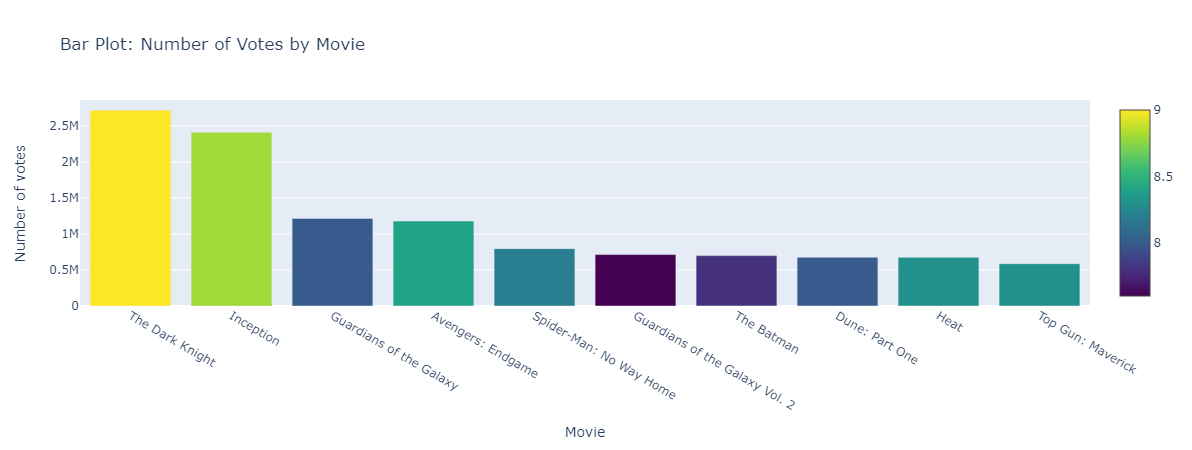

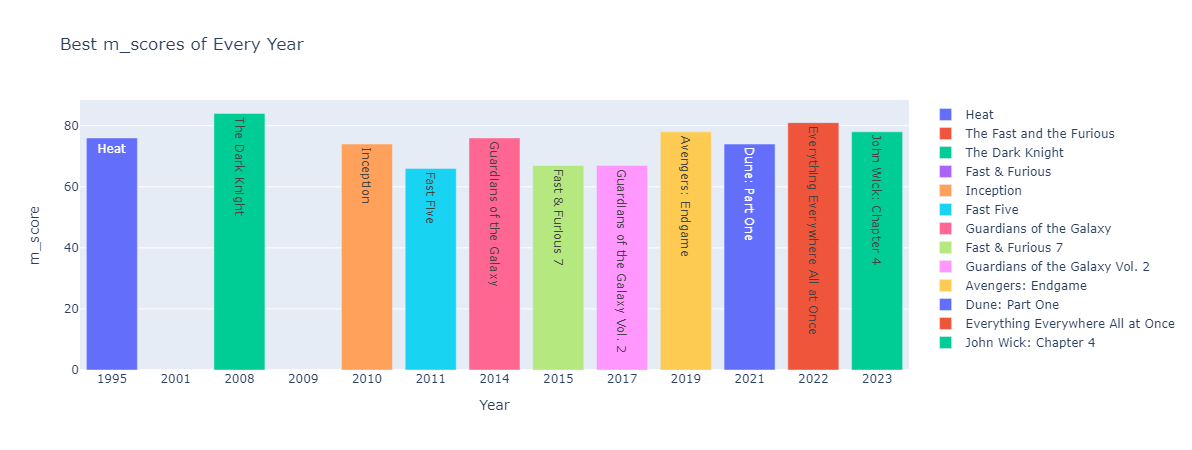

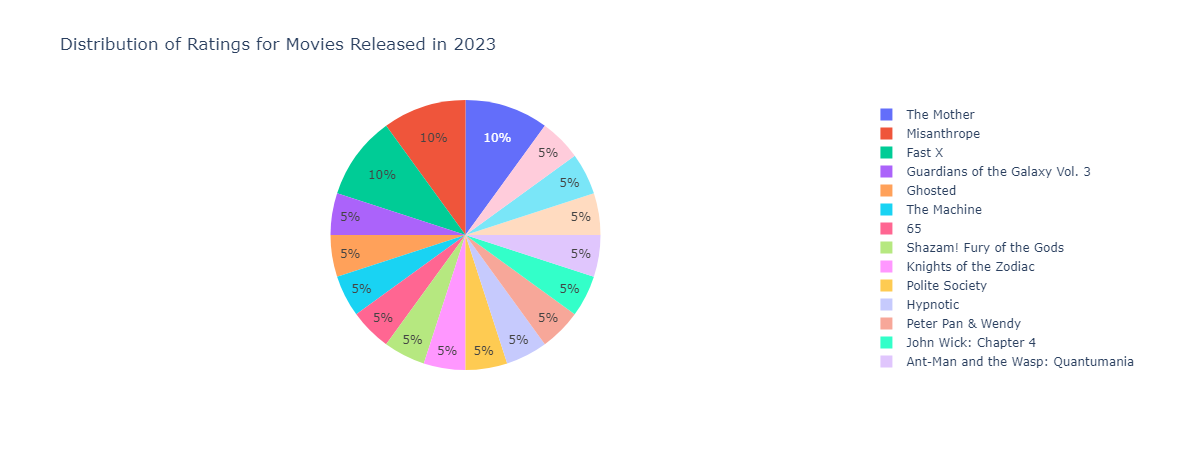

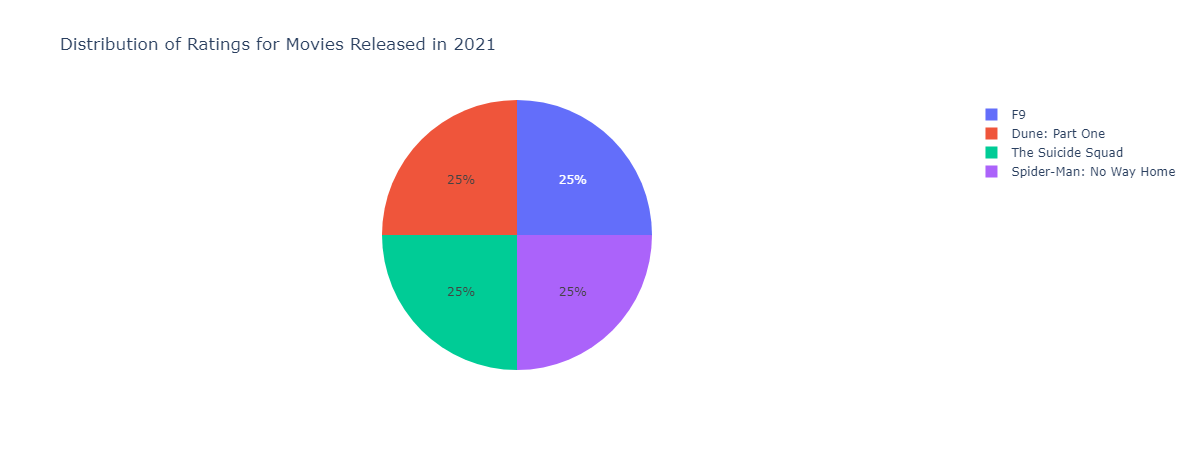